In [1]:
import numpy as np
%matplotlib inline 
import pandas as pd
import tensorflow as tf
from IPython.display import display, Image
import cv2
from PIL import Image
from tqdm import tqdm
from keras.applications.vgg19 import VGG19
from keras.utils.vis_utils import plot_model
import gc
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
import torch
from dilate_loss import dilate_loss
from torch.utils.data import DataLoader
import random
from tslearn.metrics import dtw, dtw_path
import matplotlib.pyplot as plt
import warnings
import warnings; warnings.simplefilter('ignore')

# Let's try to implement the DILATE loss method
##### and see if it gives better reuslts

                           min cpu       max cpu       avg cpu
timestamp                                                     
2017-01-01 00:00:00  715146.536821  2.223302e+06  1.229569e+06
2017-01-01 00:05:00  700473.840324  2.212393e+06  1.211322e+06
2017-01-01 00:10:00  705953.565850  2.213057e+06  1.206635e+06
2017-01-01 00:15:00  688383.073221  2.187572e+06  1.190369e+06
2017-01-01 00:20:00  688276.551033  2.183684e+06  1.180992e+06


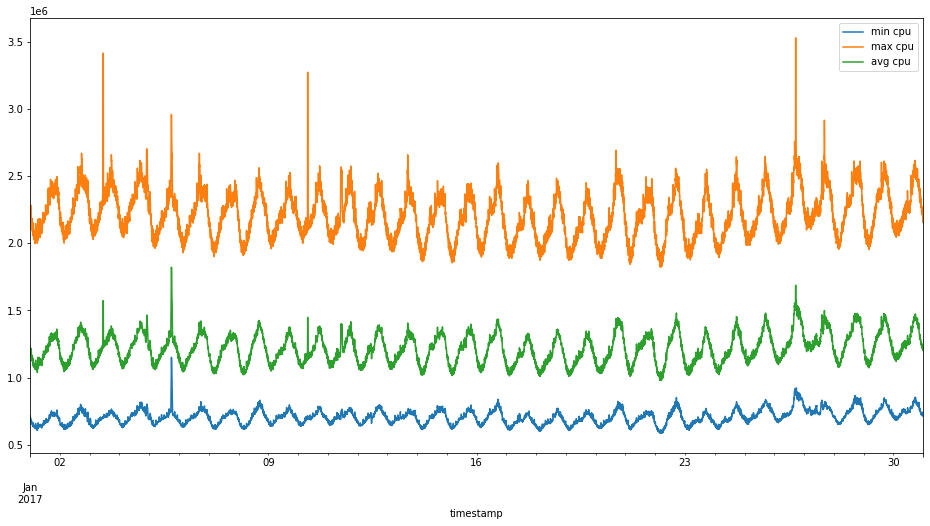

In [3]:
# let's load the dataset
df = pd.read_csv("./azure.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')
print(df.head())
df.plot(figsize=(16,8))
plt.show()

In [4]:
# create train test split
train_length = round(len(df)*0.8)
test_length = len(df) - train_length
train = df.iloc[0:train_length]
test = df.iloc[train_length:]

In [5]:
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
test = (test - train_mean) / train_std

In [6]:
# let's build another scaler for just one column and not the three
new_scaler = MinMaxScaler(feature_range = (0,1))
train_scaled = pd.DataFrame(new_scaler.fit_transform(train["avg cpu"].to_numpy().reshape(-1,1)), columns=["avg cpu"])
test_scaled = pd.DataFrame(new_scaler.fit_transform(test["avg cpu"].to_numpy().reshape(-1,1)), columns=['avg cpu'])

In [7]:
# let's scale the values of the dataset
scaler = MinMaxScaler(feature_range = (0,1)) #transform features by scaling each feature to a given range
train_scaled = pd.DataFrame(scaler.fit_transform(train), columns=df.columns)
test_scaled = pd.DataFrame(scaler.fit_transform(test), columns=df.columns)

In [8]:
def train_generator(dataset, n_lags=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - n_lags - 1):
        a = dataset.iloc[i:(i+n_lags)].to_numpy()
        dataX.append(a)
        dataY.append(dataset.iloc[i + n_lags].to_numpy())
    return (np.array(dataX), np.array(dataY))

In [9]:
TIME_STEPS = 100 
X_train, y_train = train_generator(train_scaled, n_lags = TIME_STEPS)
X_test_scaled, y_test_scaled = train_generator(test_scaled, n_lags=TIME_STEPS)
X_test, y_test = train_generator(test, n_lags=TIME_STEPS)

In [10]:
new_X_train = np.empty([X_train.shape[0], X_train.shape[1]])
for i in range(len(X_train)) : 
    for j in range(X_train.shape[1]) :
        new_X_train[i][j] = X_train[i][j][1]


new_X_test = np.empty([X_test.shape[0], X_test.shape[1]])
for i in range(len(X_test)) : 
    for j in range(X_test.shape[1]) :
        new_X_test[i][j] = X_test[i][j][1]


new_X_test_scaled = np.empty([X_test_scaled.shape[0], X_test_scaled.shape[1]])
for i in range(len(X_test_scaled)) : 
    for j in range(X_test_scaled.shape[1]) :
        new_X_test_scaled[i][j] = X_test_scaled[i][j][1]

In [11]:
new_y_train = np.empty(y_train.shape[0])
for i in range(len(y_train)) : 
    new_y_train[i] = y_train[i][1]


new_y_test = np.empty(y_test.shape[0])
for i in range(len(y_test)) : 
    new_y_test[i] = y_test[i][1]

In [12]:
# let's build the lstm model
# return sequences?? -> 
model_lstm = tf.keras.models.Sequential()
model_lstm.add(tf.keras.layers.LSTM(512,input_shape=(X_train.shape[1], 1),return_sequences=True))
model_lstm.add(tf.keras.layers.LSTM(512, return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 512)          1052672   
                                                                 
 lstm_1 (LSTM)               (None, 512)               2099200   
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 3,152,385
Trainable params: 3,152,385
Non-trainable params: 0
_________________________________________________________________


In [13]:
model_lstm.compile(loss=dilate_loss, optimizer= tf.keras.optimizers.Adam())

In [14]:
es = tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)
lr_red = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1, min_lr=0.0000001,)

In [15]:
callbacks = [es, lr_red]
history = model_lstm.fit(new_X_train, new_y_train, epochs=200, validation_split=0.25, batch_size=256, verbose=1,
                    shuffle=False,
                    callbacks = callbacks)
# would be logical to train model on mutltiple batch sizes

Epoch 1/200
> c:\users\xl892pg\appdata\local\temp\__autograph_generated_fileoe69tff8.py(14)tf__dilate_loss()
     12                 import pdb
     13                 ag__.ld(pdb).set_trace()
---> 14                 softdtw_batch = ag__.ld(soft_dtw).SoftDTWBatch.apply
     15                 D = ag__.converted_call(ag__.ld(torch).zeros, ((ag__.ld(batch_size), ag__.ld(N_output), ag__.ld(N_output)),), None, fscope)
     16 

lol
None
*** AttributeError: 'NoneType' object has no attribute 'shape'
<tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=float32>
Tensor("ExpandDims:0", shape=(None, 1), dtype=float32)
TensorShape([None, 1])
(None, 1)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\XL892PG\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\XL892PG\AppData\Local\Temp/ipykernel_20896/587303730.py", line 2, in <module>
    history = model_lstm.fit(new_X_train, new_y_train, epochs=200, validation_split=0.25, batch_size=256, verbose=1,
  File "C:\Users\XL892PG\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
    return fn(*args, **kwargs)
  File "C:\Users\XL892PG\Anaconda3\lib\site-packages\tensorflow\python\framework\func_graph.py", line 1118, in autograph_handler
    return autograph.converted_call(
bdb.BdbQuit: in user code:

    File "C:\Users\XL892PG\Anaconda3\lib\site-packages\keras\engine\training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\XL892PG\GotoMarket\IT_Capacity_Management\Azure_Dataset\dilate_loss.py", l

TypeError: object of type 'NoneType' has no len()

In [ ]:
preds = model_lstm.predict(new_X_test_scaled)
preds = new_scaler.inverse_transform(preds)
plt.rcParams["figure.figsize"] = (32,12)
TestY = pd.DataFrame(new_y_test, columns=['avg_cpu'])
PredY = pd.DataFrame(preds, columns=['avg_cpu'])

plot_avg = plt.figure(1)
plt.plot(TestY['avg_cpu'])
plt.plot(PredY['avg_cpu'])
plt.show()

In [ ]:
#-----------------------------------------------------------
# LETS CHECK HOW GOOD THE MODEL PERFORMED
#-----------------------------------------------------------
testScore_1 = math.sqrt(mean_squared_error(new_y_test[:], preds[:]))
print('Test Score: %.2f RMSE' % (testScore_1))

testScore_2 = math.sqrt(mean_absolute_error(new_y_test[:], preds[:]))
print('Test Score: %f MAE' % (testScore_2))

testScore_3 = np.mean(np.abs(preds - new_y_test)/np.abs(new_y_test)*100)
print('Test Score: %f MAPE' % (testScore_3))